# XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

from skopt import forest_minimize  # Random forest hyperparameter optimization
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.callbacks import DeltaYStopper

# Project level modules
import modules.preprocessing_functions as ppf

In [2]:
# Random State
rs = 99

In [3]:
def load_and_process(csv_path: 'str'):
    """
    Load the csv, process NAN values in the target variable, and
    drop irrelevant rows
    
    Parameters
    ----------
    csv_path : string
    
    Returns
    -------
    df : Pandas Dataframe
    """
    
    # Load csv and parse the first column as dates
    df = pd.read_csv(csv_path, parse_dates=[0])
    
    # Set NAN values in departure and arrival delay to 0
    df = ppf.process_nan_values(
        df=df,
        features_to_zero=['dep_delay', 'arr_delay']
    )
    
    # Drop flight rows that were cancelled or diverted
    df = df[
        (df['cancelled'] == 0) &
        (df['diverted'] == 0)
    ]
    
    # Drop flights with delay >3std
    df = df[
        (df['arr_delay'] < (df['arr_delay'].mean()
                            + 3 * df['arr_delay'].std()))
    ]
    
    # Drop flights with delay <-120min
    df = df[
        (df['arr_delay'] > -120)
    ]
    
    # Add stratifier
    df['is_delayed'] = 0
    df.loc[(df['arr_delay'] > 0), 'is_delayed'] = 1
    
    # # First week of January
    # df = df[
    #     (df['fl_date'] >= '2018-01-01') &  # First week of January
    #     (df['fl_date'] <= '2018-01-07')
    # ]
    
    return df

In [8]:
google_drive_path = ('~/Google Drive/My Drive/Lighthouse Labs/'
                     + 'Mid-term Project/Data-Jan/')
file_name = 'sample'

path = {
    'full' : f'{google_drive_path}2018-01.csv',
    'sample' : f'../data/{file_name}.csv'
}

In [30]:
data = load_and_process(csv_path=path['sample'])
stats = pd.read_csv('../data/feature_average_delay_stats/dest_arr_delay_stats.csv',
                   index_col=[0])

In [31]:
data

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,is_delayed
0,2018-01-04,WN,WN,WN,479,WN,N8649A,479,13232,MDW,...,23.0,0.0,0.0,0.0,48.0,NaN,NaN,NaN,NaN,1
1,2018-01-23,AA,AA_CODESHARE,AA,4645,YX,N127HQ,4645,13244,MEM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2018-01-12,WN,WN,WN,408,WN,N7711N,408,10721,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2018-01-01,UA,UA_CODESHARE,UA,4655,AX,N41104,4655,12264,IAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2018-01-28,HA,HA,HA,8,HA,N386HA,8,12173,HNL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2018-01-25,UA,UA,UA,1076,UA,N16217,1076,14635,RSW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9996,2018-01-04,AA,AA_CODESHARE,AA,4022,MQ,N645AE,4022,10599,BHM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9997,2018-01-08,WN,WN,WN,738,WN,N486WN,738,11259,DAL,...,6.0,0.0,8.0,0.0,45.0,NaN,NaN,NaN,NaN,1
9998,2018-01-06,AA,AA,AA,416,AA,N162UW,416,11057,CLT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [32]:
data['dest2'] = data['dest'].map(stats['2018_month_dest_mean_arr_delay'])

In [33]:
data[['dest', 'dest2']]

,dest,dest2
0,SMF,-2.522869
1,PHL,-0.653183
2,BWI,-2.283434
3,ALB,2.066719
4,LAS,-4.327127
...,...,...
9995,EWR,5.069970
9996,DFW,-3.503983
9997,LGA,3.487126
9998,FLL,1.380911


In [6]:
data.shape

(2120, 43)

In [15]:
def performance_stats(feature: 'str', groupby: 'str'):
    """
    
    """
    files = {
        '2018' : google_drive_path + '2018-01.csv',
        '2019' : google_drive_path + '2019-01.csv'
    }
    
    
    frames = []
    stats = pd.DataFrame()
    for yr, file in files.items():
        data = load_and_process(csv_path=file)
        
        date_filters = {
            # First week of January
            'week' : ((data['fl_date'] >= f'{yr}-01-01') &
                (data['fl_date'] <= f'{yr}-01-07')),
            # Month of January
            'month' : ((data['fl_date'] >= f'{yr}-01-01') &
                (data['fl_date'] <= f'{yr}-01-31'))
        }
            
        for timeline, date_filter in date_filters.items():
            stats[[
                f'{yr}_{timeline}_{groupby}_mean_{feature}', 
                f'{yr}_{timeline}_{groupby}_std_{feature}', 
                f'{yr}_{timeline}_{groupby}_skew_{feature}'
            ]] = (data[date_filter][[feature, groupby]]
                  .groupby(by=[groupby])
                  .agg({feature : ['mean', 'std', 'skew']})
                 )

    return stats

In [16]:
def save_stats():
    """
    
    """
    
    feature_dict = {
        'origin' : 'dep_delay',
        'origin_city_name' : 'dep_delay',
        'dest' : 'arr_delay',
        'dest_city_name' : 'arr_delay',
        'tail_num' : 'arr_delay',
        'op_unique_carrier' : 'arr_delay'
    }
    
    for k, v in feature_dict.items():
        stats = performance_stats(feature=v, groupby=k)
        stats.to_csv(f'../data/feature_average_delay_stats/{k}_{v}_stats.csv')
    
    return None

In [17]:
df = save_stats()
df

/var/folders/kl/ffj9qs1d5cd9lwrlh8wdjl640000gn/T/ipykernel_87702/2313846181.py:14: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  data = load_and_process(csv_path=file)


In [8]:
def numerify(df):
    """
    
    """
    
    feature_dict = {
        'origin' : 'dep_delay',
        'origin_city_name' : 'dep_delay',
        'dest' : 'arr_delay',
        'dest_city_name' : 'arr_delay',
        'tail_num' : 'arr_delay',
        'op_unique_carrier' : 'arr_delay'
    }
    
    for k, v in feature_dict.items():
        stats = performance_stats(feature=v, groupby=k)
        df[k] = df[k].map(stats[f'{k}_mean_{v}'])
    
    return None

In [9]:
numerify(data)
data

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,is_delayed
0,2018-01-04,WN,WN,WN,479,3.793911,71.000000,479,13232,13.714286,...,23.0,0.0,0.0,0.0,48.0,NaN,NaN,NaN,NaN,1
3,2018-01-01,UA,UA_CODESHARE,UA,4655,-0.823529,-8.000000,4655,12264,5.807692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
13,2018-01-06,AS,AS_CODESHARE,AS,2192,-3.464286,40.000000,2192,12892,12.776119,...,36.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,1
16,2018-01-05,F9,F9,F9,1282,9.138889,-20.000000,1282,11292,7.223684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19,2018-01-03,DL,DL,DL,930,-2.048309,-11.000000,930,13198,8.105263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,2018-01-06,AA,AA,AA,2528,3.194757,0.000000,2528,14100,19.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9992,2018-01-02,UA,UA,UA,1962,-1.317949,2.000000,1962,14683,5.545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9993,2018-01-06,AA,AA_CODESHARE,AA,5559,7.906250,-13.000000,5559,13495,5.937500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9996,2018-01-04,AA,AA_CODESHARE,AA,4022,9.261905,4.666667,4022,10599,5.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [10]:
# Predictor features set
X = ppf.flight_test_features(data, purged=True)
# Target variable
y = data[['arr_delay', 'is_delayed']]

In [11]:
X

,fl_date,op_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,distance
0,2018-01-04,3.793911,71.000000,13.714286,18.634146,14.882353,14.882353,845,1125,1790
3,2018-01-01,-0.823529,-8.000000,5.807692,8.589286,-1.800000,-1.800000,1235,1406,325
13,2018-01-06,-3.464286,40.000000,12.776119,12.776119,9.500000,9.500000,1323,1440,256
16,2018-01-05,9.138889,-20.000000,7.223684,7.223684,14.402299,12.347826,2002,2325,888
19,2018-01-03,-2.048309,-11.000000,8.105263,8.105263,2.840000,2.840000,1022,1315,629
...,...,...,...,...,...,...,...,...,...,...
9991,2018-01-06,3.194757,0.000000,19.023256,19.023256,0.489362,0.489362,810,1050,2176
9992,2018-01-02,-1.317949,2.000000,5.545455,5.545455,14.402299,12.347826,610,856,1041
9993,2018-01-06,7.906250,-13.000000,5.937500,5.937500,2.542857,4.081967,1101,1426,969
9996,2018-01-04,9.261905,4.666667,5.875000,5.875000,0.197183,0.197183,922,1138,597


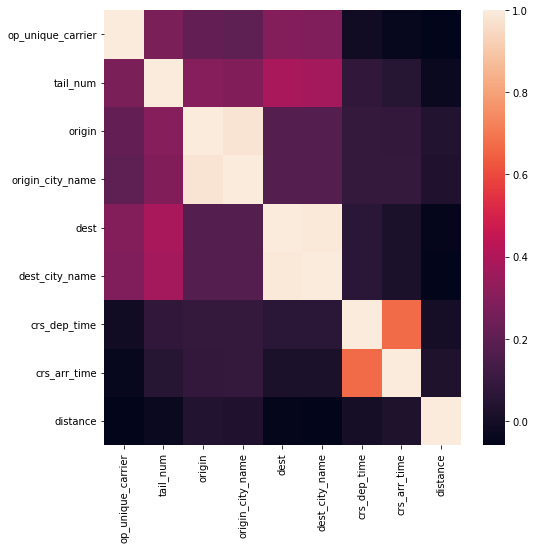

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(X.corr())
plt.show()

## Data Split

## Preprocessing

In [13]:
# NA replacement
# Split X into categorical and numeric features
# For numeric
# Scale and transform
# For categorical
# One hot encode/dummy

In [14]:
X_numerical, X_categorical = ppf.numerical_categorical_split(df=X)

#### One hot encoding
Doing One hot encoding before the train test split is based on the Machine Learning Mastery tutorial [Data Preparation for Gradient Boosting with XGBoost in Python](https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/)

In [15]:
# One hot encoding
X_cat_one_hot = pd.get_dummies(
    X_categorical,
    prefix=X_categorical.columns[1:],
    # will fl_date be encoded if there was more than one date?
    drop_first=True
)

# Reconstitue original data table with one hot encoded features
X_one_hot = pd.concat([X_cat_one_hot, X_numerical], axis=1)

ValueError: Length of 'prefix' (6) did not match the length of the columns being encoded (0).

### Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y['arr_delay'],
    train_size=0.8,
    test_size=0.2,
    stratify=y['is_delayed'],
    random_state=rs
)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Numerical

In [17]:
# Convert fligth date to an integer
X_train.loc[:, 'fl_date'] = X_train['fl_date'].view(int) / 1e11
X_test.loc[:, 'fl_date'] = X_test['fl_date'].view(int) / 1e11

# Scale numeric features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X=X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X=X_test),
    columns=X_test.columns
    )

In [21]:
X_train

,fl_date,op_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,distance
0,15148512.0,9.138889,-8.0,7.223684,7.223684,-4.288889,-4.288889,1234,1439,1024
1,15151968.0,-0.232673,-12.0,0.000000,0.000000,-1.169811,-1.169811,1800,1942,421
2,15152832.0,3.194757,-18.0,-0.434783,-0.434783,0.197183,0.197183,735,1318,1616
3,15148512.0,-2.654545,-34.0,6.857143,6.857143,2.840000,2.840000,1738,1904,201
4,15147648.0,5.492958,22.0,25.833333,25.833333,11.875000,11.875000,915,1137,1092
...,...,...,...,...,...,...,...,...,...,...
1691,15152832.0,-0.232673,43.5,5.854545,5.854545,-3.200000,-3.200000,1048,1414,848
1692,15148512.0,7.906250,-31.0,-6.000000,-6.000000,0.653333,0.653333,705,805,83
1693,15149376.0,3.793911,-22.0,11.000000,8.589286,-1.080000,-1.080000,1655,1755,562
1694,15152832.0,3.793911,-1.0,11.795918,11.795918,14.142857,14.142857,1950,2130,515


In [22]:
X_train_scaled

,fl_date,op_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,distance
0,0.166667,0.433159,0.219512,0.195532,0.195532,0.169578,0.169578,0.520869,0.609673,0.247383
1,0.833333,0.227621,0.200000,0.139535,0.139535,0.186258,0.186258,0.761925,0.823080,0.093439
2,1.000000,0.302792,0.170732,0.136164,0.136164,0.193568,0.193568,0.308348,0.558337,0.398519
3,0.166667,0.174504,0.092683,0.192691,0.192691,0.207701,0.207701,0.735520,0.806958,0.037273
4,0.000000,0.353196,0.365854,0.339793,0.339793,0.256016,0.256016,0.385009,0.481544,0.264743
...,...,...,...,...,...,...,...,...,...,...
1691,1.000000,0.227621,0.470732,0.184919,0.184919,0.175401,0.175401,0.441652,0.599067,0.202451
1692,0.166667,0.406125,0.107317,0.093023,0.093023,0.196007,0.196007,0.295571,0.340687,0.007148
1693,0.333333,0.315933,0.151220,0.224806,0.206118,0.186738,0.186738,0.700170,0.743742,0.129436
1694,1.000000,0.315933,0.253659,0.230976,0.230976,0.268144,0.268144,0.825809,0.902843,0.117437


## Training

### Default

[XGBoost.train](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=xgboost%20train#xgboost.train)

>```Python
xgb.train(params, dtrain, num_boost_round=10,  
evals=(), obj=None, feval=None,  
maximize=None, early_stopping_rounds=None, evals_result=None,  
verbose_eval=True, xgb_model=None, callbacks=None)```

[XGBRegressor().fit](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=fit#xgboost.XGBRegressor.fit)

>```Python
xgb.XGBRegressor().fit(X, y, *,  
sample_weight=None, base_margin=None, eval_set=None,  
eval_metric=None, early_stopping_rounds=None, verbose=True,  
xgb_model=None, sample_weight_eval_set=None, base_margin_eval_set=None,  
feature_weights=None, callbacks=None)```


In [23]:
xg_reg_default = xgb.XGBRegressor(random_state=rs)
xg_reg_default.fit(X=X_train_scaled, y=y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=99,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
y_pred_default = xg_reg_default.predict(X_test_scaled)

In [26]:
# Root mean squared error
rmse = mean_squared_error(
    y_true=y_test,
    y_pred=y_pred_default,
    squared=False
)
print(f'RMSE: {rmse}')

RMSE: 13.180281260860644


In [30]:
y_pred_df = pd.DataFrame(y_pred_default)

In [39]:
y_pred_df.skew()

0    2.141335
dtype: float32

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

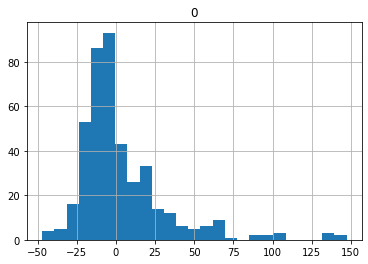

In [38]:
y_pred_df.hist(bins=25)

<BarContainer object of 10 artists>

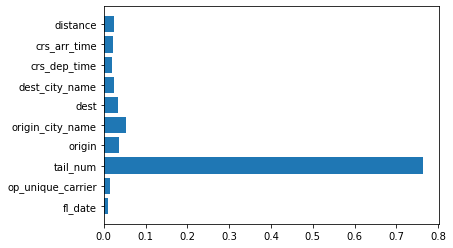

In [29]:
plt.barh(X_train_scaled.columns, xg_reg_default.feature_importances_)

In [ ]:
params = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [3, 6, 10],
    'learning_rate' : [0.01, 0.1, 0.3, 0.5],
    'objective' : 'reg:squarederror',
    'gamma' : [0, 0.1, 0.2]
    'reg_lambda' : ,
    'random_state'=rs
}

In [ ]:
GS = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=params,
    n_jobs=-1
)

## Forest Minimize

In [ ]:
reg = xgb.XGBRegressor(random_state=rs)

space = space = [
    Real(10**-3, 10**0, prior='log-uniform', name='learning_rate'),
    Integer(10, 100, name='n_estimators'),
    Integer(1, 10, name='max_depth'),
    Real(1, 6., name='min_child_weight'),
    Real(0, 0.5, name='gamma'),
    Real(0.5, 1., name='subsample'),
    Real(0.5, 1., name='colsample_bytree'),
    Real(0, 5., name='reg_lambda'),  #  L2 regularization
    Real(0, 5., name='reg_alpha'),  #  L1 regularization
]

In [ ]:
@use_named_args(space)
def tune_xgbr(**params):
    # Implementation from Pedro Couto (https://www.kaggle.com/general/17120)
    """
    Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters
    ----------
    Tuples with information about the range that the optimizer should
    use for that parameter, as well as the behaviour that it should
    follow in that range.

    Returns
    -------
    float : the metric that should be minimized.
        If the objective is maximization, then the negative of the
        desired metric must be returned. e.g. AUC for classifiers
    """
    
    reg.set_params(**params)

    print(params)

    #Cross-Validation in order to avoid overfitting
    rmse = -cross_val_score(
        estimator=reg,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='neg_root_mean_squared_error'
    )

    # as the function is minimization (forest_minimize)
    return rmse.mean()

In [ ]:
result = forest_minimize(
    func=tune_xgbr,
    dimensions=space,
    n_calls=10,  # default=100
    n_initial_points=10,  # default=10
    random_state=rs,
    verbose=True,
    callback=[DeltaYStopper(delta=0.0001, n_best=5)],
    n_jobs=-1
)

Test 1
```Python
{'learning_rate': 0.001427327650456945, 'n_estimators': 45, 'max_depth': 6, 'min_child_weight': 5.577312494899226, 'gamma': 0.46958871144265596, 'subsample': 0.9187467962876275, 'colsample_bytree': 0.7163946675955536, 'reg_lambda': 3.580564759611335, 'reg_alpha': 4.256719953358928}
```

In [ ]:
# See documentation for all XGBoost parameters
# https://xgboost.readthedocs.io/en/stable/parameter.html

# typical values from
# https://machinelearningmastery.com/xgboost-for-regression/


optimum_parameters = {
    # Tree Booster Parameters
    'learning_rate' : 0.001427327650456945,  # learning_rate default 0.3 range [0, 1]
    'n_estimators' : 45,  # numer of trees
    'max_depth' : 6,  # default 6 typical 1–10
    'min_child_weight' : 5.577312494899226,
    'gamma' : 0.46958871144265596,
    'subsample' : 0.9187467962876275,
    'colsample_bytree' : 0.7163946675955536,  # default 1 range (0, 1]
    'reg_lambda' : 3.580564759611335,  # L2 regularization default 1
    'reg_alpha' : 0,  # L1 regularization default 0
    # Learning Task Parameters
    'objective' : 'reg:squarederror',  # default reg:squarederror
    'eval_metric' : 'rmse',  # regression default 'rmse'
    "seed" : rs  # random seed
}


In [ ]:
# SKlearn wrapper
xg_reg = xgb.XGBRegressor(
    objective='reg:linear',
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 5,
    alpha = 10,
    n_estimators = 10
)

In [ ]:
xg_reg.fit(X_train, y_train)

## Predicting 

In [ ]:
y_pred = xg_reg.predict(X_test)

## Model Evaluation

In [ ]:
# Root mean squared error
rmse = np.sqrt(mean_squared_error(y_true=y_test,
                                  y_pred=y_pred))
print(f'RMSE: {rmse}')

## Cross validation

In [ ]:
params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10}

cv_results = xgb.cv(
    dtrain=DMat_train,
    params=params,
    nfold=10,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="rmse",
    as_pandas=True,
    seed=rs
)

cv_results

## Visualize

In [ ]:
xg_reg = xgb.train(
    params=params,
    dtrain=DMat_train,
    num_boost_round=10
)

In [ ]:
ax = xgb.plot_tree(booster=xg_reg, num_trees=0)
fig = ax.figure
fig.set_size_inches(50, 10)

In [ ]:
# Feature Importance
ax = xgb.plot_importance(xg_reg)
fig = ax.figure
fig.set_size_inches(12, 9)